# データの準備

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

In [2]:
housing = fetch_california_housing()

X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = pd.DataFrame(housing.target, columns=['Price'])

# データを分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# データ数をチェック
X_train.shape, X_test.shape

((16512, 8), (4128, 8))

In [3]:
# 説明変数と目的変数をそれぞれpandasのデータフレームに格納
train_set = pd.concat([X_train, y_train], axis=1)
test_set = pd.concat([X_test, y_test], axis=1)

# 訓練データの要約統計量
train_set.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.880754,28.608285,5.435235,1.096685,1426.453004,3.096961,35.643149,-119.582290,2.071947
std,1.904294,12.602499,2.387375,0.433215,1137.056380,11.578744,2.136665,2.005654,1.156226
min,0.499900,1.000000,0.888889,0.333333,3.000000,0.692308,32.550000,-124.350000,0.149990
25%,2.566700,18.000000,4.452055,1.006508,789.000000,2.428799,33.930000,-121.810000,1.198000
50%,3.545800,29.000000,5.235874,1.049286,1167.000000,2.817240,34.260000,-118.510000,1.798500
75%,4.773175,37.000000,6.061037,1.100348,1726.000000,3.280000,37.720000,-118.010000,2.651250
max,15.000100,52.000000,141.909091,25.636364,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [4]:
# 検証用データの要約統計量
test_set.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.000000,4128.00000,4128.00000,4128.000000
mean,3.830338,28.764293,5.404059,1.096637,1421.571705,2.965431,35.58671,-119.51936,2.055003
std,1.881515,12.518304,2.794717,0.610196,1114.023136,1.753316,2.13276,1.99447,1.144870
min,0.499900,1.000000,0.846154,0.500000,8.000000,1.263566,32.54000,-124.19000,0.149990
25%,2.548500,18.000000,4.396633,1.004338,781.000000,2.435365,33.93000,-121.69000,1.192750
50%,3.500000,29.000000,5.192764,1.046715,1160.000000,2.823586,34.23000,-118.47000,1.786500
75%,4.645925,37.000000,6.008889,1.095908,1722.000000,3.289374,37.70000,-117.99000,2.630000
max,15.000100,52.000000,132.533333,34.066667,16122.000000,83.171429,41.81000,-114.58000,5.000010


テストセットは未知のデータとするので、最後の評価用にとっておき、**訓練データセット**を前処理します。

In [5]:
def round_number(df):
    """
    指定された属性の値を四捨五入し整数に置き換える
    """
    ave_columns = ['AveRooms', 'AveBedrms', 'AveOccup']

    for col in ave_columns:
        df[col] = np.round(df[col])
    return df

# dfを返す

In [6]:
def std_exclude(df):
    """
    標準偏差の２倍以上の値は取り除く
    """
    columns = df[['MedInc', 'AveRooms', 'Population', 'AveOccup']].columns

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        boder = np.abs(df[col] - mean) / std
        df = df[(boder < 2)]

    return df

# dfを返す

In [7]:
def category(df):
    """
   その区域の人口は、少ない（few）か、普通（usually）か、多い（many）か。
    大体のの区域では600人から3000人ということから、この範囲を指標とする。
    """
    if df < 600:
        return 'few'
    elif df > 3000:
        return 'many'
    else:
        return 'usually'

# dfを返す

In [8]:
""" 上３つの関数をまとめたカスタム変換器"""
def custom_conversion(dataframe):
    df = dataframe.copy()
    df = round_number(df)

    # サンプルの調査ミスとして取り除く
    df = df[df['HouseAge'] < 52]

    # サンプルの調査ミスとして取り除く
    df = df[df['Price'] < 5]
    df = std_exclude(df)

    # 平均部屋数に対して平均寝室数を比較する
    df['Bedrms_per_Rooms'] = df['AveBedrms'] / df['AveRooms']
    df['Population_Feature'] = df['Population'].apply(category)

    # カテゴリー属性をダミー変数化する
    feature_dummies = pd.get_dummies(df['Population_Feature'], drop_first=True)
    df = pd.concat([df, feature_dummies], axis=1)

    # Xを説明変数、yを目的変数に代入しておく
    X = df.drop(['AveBedrms', 'Price', 'Population_Feature'], axis=1)
    y = df['Price']

    return X, y

In [9]:
X, y = custom_conversion(train_set)

In [10]:
X.describe()

,MedInc,HouseAge,AveRooms,Population,AveOccup,Latitude,Longitude,Bedrms_per_Rooms,many,usually
count,13463.000000,13463.000000,13463.000000,13463.000000,13463.000000,13463.000000,13463.000000,13463.000000,13463.000000,13463.000000
mean,3.527003,27.753027,5.149892,1327.312783,2.934561,35.623993,-119.526978,0.207091,0.035950,0.840897
std,1.339388,11.232520,1.117769,723.261191,0.759399,2.157767,1.984480,0.054631,0.186173,0.365785
min,0.643300,1.000000,1.000000,6.000000,1.000000,32.550000,-124.300000,0.000000,0.000000,0.000000
25%,2.492050,18.000000,4.000000,810.000000,2.000000,33.930000,-121.590000,0.166667,0.000000,1.000000
50%,3.380400,28.000000,5.000000,1183.000000,3.000000,34.260000,-118.470000,0.200000,0.000000,1.000000
75%,4.456150,36.000000,6.000000,1699.000000,3.000000,37.680000,-118.000000,0.250000,0.000000,1.000000
max,6.841900,51.000000,9.000000,3806.000000,5.000000,41.950000,-114.550000,1.000000,1.000000,1.000000


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_s = scaler.fit_transform(X)

# 複雑な機械学習モデルを使って訓練を行う

In [12]:
# LinearRegression で検証
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_s, y)

lin_pred = lin_reg.predict(X_s)
lin_mse = mean_squared_error(y, lin_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.5754619586800496

## 複数のモデルで検証する
## 1_SVM（サポートベクトルマシン）

In [14]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(X_s, y)

svm_pred = svm_reg.predict(X_s)
svm_mse = mean_squared_error(y, svm_pred)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

0.4970621662313965

## 2_RandomForest（ランダムフォレスト）

In [15]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_s, y)

forest_pred = forest_reg.predict(X_s)
forest_mse = mean_squared_error(y, forest_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.1619785783725724

## 3_GradientBoostingTree（勾配ブースティング決定木）

In [16]:
from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(random_state=42)
gb_reg.fit(X_s, y)

gb_pred = gb_reg.predict(X_s)
gb_mse = mean_squared_error(y, gb_pred)
gb_rmse = np.sqrt(gb_mse)
gb_rmse


0.4628402048901585

## 4_MLP（マルチレイヤーパーセプトロン）

In [17]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(max_iter=300, random_state=42)
mlp_reg.fit(X_s, y)

mlp_pred = mlp_reg.predict(X_s)
mlp_mse = mean_squared_error(y, mlp_pred)
mlp_rmse = np.sqrt(mlp_mse)
mlp_rmse

0.4682285084580455

In [18]:
accuracy = pd.DataFrame([svm_rmse, forest_rmse, gb_rmse, mlp_rmse],
                         index=['SVM', 'RandomForest', 'GBoost', 'MLP'], columns=['Normal'])
accuracy

,Normal
SVM,0.497062
RandomForest,0.161979
GBoost,0.462840
MLP,0.468229


# 交差検証を使って再度評価を行う
## SVM（交差検証）

In [19]:
from sklearn.model_selection import cross_val_score

 # scornigは評価方法。ここでは平均二乗誤差
 # cvは検証回数
svm_scores = cross_val_score(svm_reg, X_s, y, scoring='neg_mean_squared_error', cv=5)
svm_scores


array([-0.26520524, -0.25643939, -0.2596777 , -0.27091169, -0.27895904])

In [20]:
svm_rmse_score = np.sqrt(-svm_scores)

In [21]:
def display_scores(scores):
    print('Score: ', scores)
    print('\n')
    print('Mean: ', scores.mean())
    print('\n')
    print('Standard deviation: ', scores.std())

In [22]:
display_scores(svm_rmse_score)

Score:  [0.51498082 0.50639845 0.50958581 0.52049178 0.52816573]


Mean:  0.515924515531181


Standard deviation:  0.007778470139615861


## RandamForest（交差検証）

In [23]:
forest_scores = cross_val_score(forest_reg, X_s, y, scoring='neg_mean_squared_error', cv=5)

forest_rmse_score = np.sqrt(-forest_scores)

display_scores(forest_rmse_score)

Score:  [0.43767776 0.44131438 0.42937464 0.44081916 0.44592454]


Mean:  0.43902209575948004


Standard deviation:  0.005495606730974703


## GradientBoosting（交差検証）

In [24]:
gb_scores = cross_val_score(gb_reg, X_s, y, scoring='neg_mean_squared_error', cv=5)

gb_rmse_score = np.sqrt(-gb_scores)

display_scores(gb_rmse_score)

Score:  [0.47812011 0.4643197  0.46411158 0.48587029 0.480453  ]


Mean:  0.47457493746782325


Standard deviation:  0.008824474136758255


## MLP（交差検証）

In [25]:
mlp_scores = cross_val_score(mlp_reg, X_s, y, scoring='neg_mean_squared_error', cv=5)

mlp_rmse_score = np.sqrt(-mlp_scores)

display_scores(mlp_rmse_score)

Score:  [0.49511224 0.48278609 0.48395667 0.5037626  0.50544144]


Mean:  0.49421180941259424


Standard deviation:  0.009527304188063293


In [26]:
accuracy['CrossValidation'] = [svm_rmse_score.mean(),
                               forest_rmse_score.mean(),
                               gb_rmse_score.mean(),
                               mlp_rmse_score.mean()]
accuracy

,Normal,CrossValidation
SVM,0.497062,0.515925
RandomForest,0.161979,0.439022
GBoost,0.462840,0.474575
MLP,0.468229,0.494212


# グリッドサーチとランダムサーチ

In [27]:
# SVM（グリッドサーチ）
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

 # C: 正則化の強度
 # kernel: カーネル関数
param_grid = [
            {'C': [0.001, 0.01, 1, 10],
             'gamma': ['auto', 'scale'],
             'kernel': ['rbf', 'linear']}
]

svm_reg = SVR()

 # cvは交差検証、scoringは評価方法
svm_grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

svm_grid_search.fit(X_s, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.001, 0.01, 1, 10], 'gamma': ['auto', 'scale'],
                          'kernel': ['rbf', 'linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [28]:
svm_grid_search.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

In [29]:
svm_grid_pred = svm_grid_search.best_estimator_.predict(X_s)
svm_grid_mse = mean_squared_error(y, svm_grid_pred)
svm_grid_rmse = np.sqrt(svm_grid_mse)
svm_grid_rmse

0.4667832146849867

In [30]:
# RandomForest（グリッドサーチ）
# max_depth: 最大ノード数
 # n_estimators: 決定木の個数
param_grid = [
            {'max_depth': [5, 6, 7],
             'n_estimators': [300, 400, 500],
             'random_state': [42]}
]

 # このように辞書を分割して作成することもできる
"""
param_grid = [
            {'bootstrap': [True], ......, .......},
            {'bootstrap': [False], ....., ......},
]
"""

forest_reg = RandomForestRegressor()

forest_grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

forest_grid_search.fit(X_s, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [31]:
forest_grid_search.best_params_

{'max_depth': 7, 'n_estimators': 400, 'random_state': 42}

In [32]:
forest_grid_pred = forest_grid_search.best_estimator_.predict(X_s)
forest_grid_mse = mean_squared_error(y, forest_grid_pred)
forest_grid_rmse = np.sqrt(forest_grid_mse)
forest_grid_rmse

0.47944300298066644

In [33]:
# GradientBoosting（グリッドサーチ）
 # max_depth: 最大ノード数
 # n_estimators: 決定木の個数
param_grid = [
            {'max_depth': [5, 6, 7],
             'n_estimators': [300, 400, 500],
             'random_state': [42]}
]

gb_reg = GradientBoostingRegressor()

gb_grid_search = GridSearchCV(gb_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

gb_grid_search.fit(X_s, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [34]:
gb_grid_search.best_params_

{'max_depth': 7, 'n_estimators': 500, 'random_state': 42}

In [35]:
gb_grid_pred = gb_grid_search.best_estimator_.predict(X_s)
gb_grid_mse = mean_squared_error(y, gb_grid_pred)
gb_grid_rmse = np.sqrt(gb_grid_mse)
gb_grid_rmse

0.13605815102288585

In [36]:
# MLP（ランダムサーチ）
 # hidden_layer_sizes: ニューロンと層の数
 # max_iter: 訓練の回数
param_random = {'hidden_layer_sizes': [(100),
                                       (100, 100),
                                       (50, 50, 50),
                                       (20, 50, 80, 50, 20),
                                       (20, 30, 50, 30, 20, 10)],
                 'max_iter': [300, 1000],
                 'random_state': [42]}

mlp_reg = MLPRegressor()

 # n_jobs: -1は全てのプロセッサを使用する
 # n_iter: デフォルトでは１０の組み合わせとなっている
mlp_random_search = RandomizedSearchCV(mlp_reg,
                                       param_random,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='neg_mean_squared_error',
                                       random_state=42)

mlp_random_search.fit(X_s, y)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=MLPRegressor(activation='relu', alpha=0.0001,
                                          batch_size='auto', beta_1=0.9,
                                          beta_2=0.999, early_stopping=False,
                                          epsilon=1e-08,
                                          hidden_layer_sizes=(100,),
                                          learning_rate='constant',
                                          learning_rate_init=0.001,
                                          max_fun=15000, max_iter=200,
                                          momentum=0.9, n_iter_no_change=10,
                                          nesterovs_momentum=True, power_t=0.5,
                                          random_...
                                          validation_fraction=0.1,
                                          verbose=False, warm_start=False),
                   iid='deprecated', n_iter=10

In [37]:
mlp_random_search.best_params_

{'random_state': 42, 'max_iter': 300, 'hidden_layer_sizes': 100}

In [38]:
mlp_random_pred = mlp_random_search.best_estimator_.predict(X_s)
mlp_random_mse = mean_squared_error(y, mlp_random_pred)
mlp_random_rmse = np.sqrt(mlp_random_mse)
mlp_random_rmse

0.4682285084580455

In [39]:
accuracy['Grid_or_Random_Search'] = [svm_grid_rmse,
                                     forest_grid_rmse,
                                     gb_grid_rmse,
                                     mlp_random_rmse]

accuracy

,Normal,CrossValidation,Grid_or_Random_Search
SVM,0.497062,0.515925,0.466783
RandomForest,0.161979,0.439022,0.479443
GBoost,0.462840,0.474575,0.136058
MLP,0.468229,0.494212,0.468229


# 最高推定器での交差検証＆最良の機械学習モデルで最後の評価

最後に、出揃った最高の各機械学習モデルを交差検証にかけて、一番最良だった機械学習モデルでテストセットでの評価を行っていきたいと思います。

グリッドサーチやランダムサーチを行った推定器のbest_estimator_属性を使用して、それぞれ交差検証を行っていきます。

In [40]:
# SVM（最高推定器での交差検証）
svm_scores = cross_val_score(svm_grid_search.best_estimator_, X_s, y, scoring='neg_mean_squared_error', cv=5)

svm_best_rmse_score = np.sqrt(-svm_scores)

display_scores(svm_best_rmse_score)

Score:  [0.50802572 0.49847396 0.50282046 0.50834014 0.5181417 ]


Mean:  0.5071603973281643


Standard deviation:  0.006588154003046234


In [41]:
# RandomForest（最高推定器での交差検証）
forest_scores = cross_val_score(forest_grid_search.best_estimator_, X_s, y, scoring='neg_mean_squared_error', cv=5)

forest_best_rmse_score = np.sqrt(-forest_scores)

display_scores(forest_best_rmse_score)

Score:  [0.51780804 0.50198563 0.50527514 0.51992336 0.51482569]


Mean:  0.5119635710774529


Standard deviation:  0.0070710987015029335


In [42]:
# GradientBoosting（最高推定器での交差検証）
gb_scores = cross_val_score(gb_grid_search.best_estimator_, X_s, y, scoring='neg_mean_squared_error', cv=5)

gb_best_rmse_score = np.sqrt(-gb_scores)

display_scores(gb_best_rmse_score)

Score:  [0.40707075 0.41113756 0.40215462 0.40523018 0.41699065]


Mean:  0.4085167506258438


Standard deviation:  0.005138966728576394


In [43]:
# MLP（最高推定器での交差検証）
mlp_scores = cross_val_score(mlp_random_search.best_estimator_, X_s, y, scoring='neg_mean_squared_error', cv=5)

mlp_best_rmse_score = np.sqrt(-mlp_scores)

display_scores(mlp_best_rmse_score)

Score:  [0.49511224 0.48278609 0.48395667 0.5037626  0.50544144]


Mean:  0.49421180941259424


Standard deviation:  0.009527304188063293


In [44]:
accuracy['Search_CV'] = [svm_best_rmse_score.mean(),
                         forest_best_rmse_score.mean(),
                         gb_best_rmse_score.mean(),
                         mlp_best_rmse_score.mean()]

accuracy

,Normal,CrossValidation,Grid_or_Random_Search,Search_CV
SVM,0.497062,0.515925,0.466783,0.507160
RandomForest,0.161979,0.439022,0.479443,0.511964
GBoost,0.462840,0.474575,0.136058,0.408517
MLP,0.468229,0.494212,0.468229,0.494212


In [45]:
# 平均をだす
accuracy.mean(axis=1).sort_values()

GBoost          0.370498
RandomForest    0.398102
MLP             0.481220
SVM             0.496733
dtype: float64

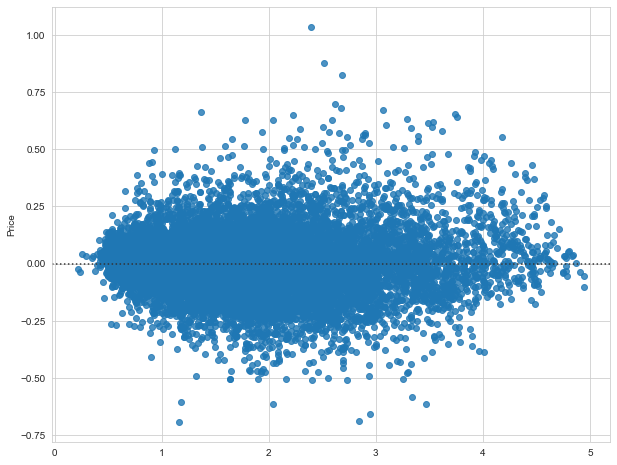

In [46]:
plt.figure(figsize=(10, 8))
sns.residplot(gb_grid_pred, y - gb_grid_pred)
plt.savefig('gb_train_resid.png')
plt.show()

# 最も最良であるモデルを使う

In [47]:
X_test, y_test = custom_conversion(test_set)

X_test_s = scaler.transform(X_test)

best_pred = gb_grid_search.best_estimator_.predict(X_test_s)
best_mse = mean_squared_error(y_test, best_pred)
best_rmse = np.sqrt(best_mse)
best_rmse

0.3935778643820838

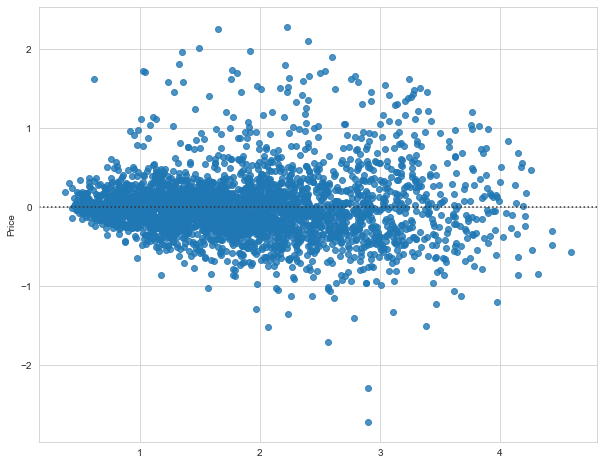

In [48]:
plt.figure(figsize=(10, 8))
sns.residplot(best_pred, y_test - best_pred)
plt.savefig('gb_test_resid.png')
plt.show()

# 最良のモデルをpickleファイルに保存

In [49]:
import pickle

with open('best_model.pickle', 'wb') as f:
    pickle.dump(gb_grid_search.best_estimator_, f)

In [50]:
with open('best_model.pickle', 'rb') as f:
    best_model = pickle.load(f)

best_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)